<a href="https://colab.research.google.com/github/diegorabelorn/IA/blob/main/IA_Parte2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install scikit-fuzzy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 11.3 MB/s eta 0:00:00


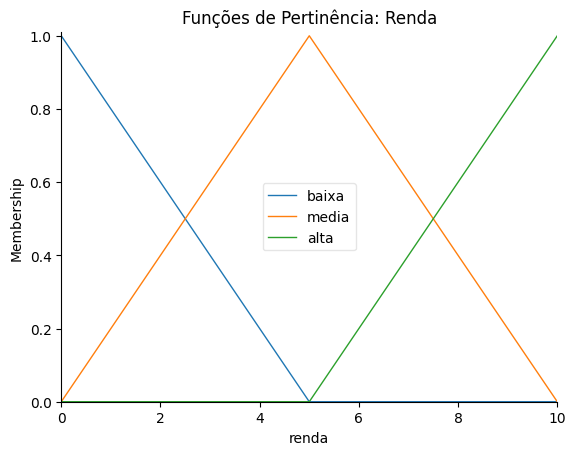

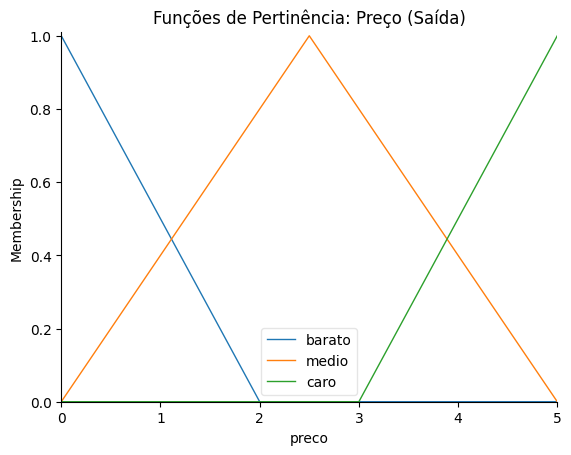

Gerando Superfície de Controle 3D...


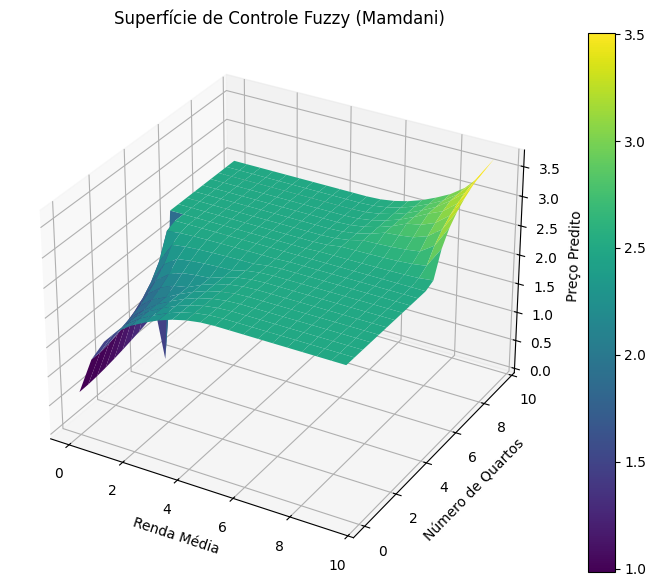

Calculando métricas em uma amostra dos dados (pode demorar um pouco)...

[ Resultados Modelo Fuzzy Mamdani ]
MSE: 1.2130
R²: -0.2706


In [2]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import mean_squared_error, r2_score

# --- 1. Preparação dos Dados (Simplificado para 2 Variáveis) ---
dados = fetch_california_housing(as_frame=True)
df = dados.frame
# Vamos usar apenas 'MedInc' (Renda) e 'AveRooms' (Média de Quartos) para prever 'MedHouseVal'
X = df[['MedInc', 'AveRooms']].values
y = df['MedHouseVal'].values

# Limitando os dados para melhor visualização fuzzy (removendo outliers extremos para o universo de discurso)
# Renda até 10 e Quartos até 10
mask = (df['MedInc'] <= 10) & (df['AveRooms'] <= 10)
X_fuzzy = df.loc[mask, ['MedInc', 'AveRooms']].values
y_fuzzy = df.loc[mask, 'MedHouseVal'].values

# --- 2. Definição das Variáveis Linguísticas (Universo de Discurso) ---

# Antecedentes (Entradas)
renda = ctrl.Antecedent(np.arange(0, 10.1, 0.1), 'renda')
quartos = ctrl.Antecedent(np.arange(0, 10.1, 0.1), 'quartos')

# Consequente (Saída)
preco = ctrl.Consequent(np.arange(0, 5.1, 0.1), 'preco')

# --- 3. Funções de Pertinência (Membership Functions) ---

# A) Modelo 1: MAMDANI (Triangular - trimf)
# Criando conjuntos automaticamente (poor, average, good) ou customizado:
renda.automf(3, names=['baixa', 'media', 'alta'])
quartos.automf(3, names=['pequeno', 'medio', 'grande'])

# Saída Preço (Barato, Medio, Caro)
preco['barato'] = fuzz.trimf(preco.universe, [0, 0, 2])
preco['medio'] = fuzz.trimf(preco.universe, [0, 2.5, 5])
preco['caro'] = fuzz.trimf(preco.universe, [3, 5, 5])

# Visualização das Funções de Pertinência (Requisito do trabalho)
renda.view()
plt.title('Funções de Pertinência: Renda')
plt.show()

preco.view()
plt.title('Funções de Pertinência: Preço (Saída)')
plt.show()

# --- 4. Regras Fuzzy (Base de Conhecimento) ---
# Definindo regras lógicas simples baseadas na intuição do dataset
rule1 = ctrl.Rule(renda['baixa'] & quartos['pequeno'], preco['barato'])
rule2 = ctrl.Rule(renda['baixa'] & quartos['grande'], preco['medio'])
rule3 = ctrl.Rule(renda['media'], preco['medio'])
rule4 = ctrl.Rule(renda['alta'] & quartos['pequeno'], preco['medio'])
rule5 = ctrl.Rule(renda['alta'] & quartos['grande'], preco['caro'])

# --- 5. Sistema de Controle e Simulação (Mamdani) ---

sistema_controle = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5])
modelo_fuzzy = ctrl.ControlSystemSimulation(sistema_controle)

# --- 6. Curva de Mapeamento (Superfície de Controle 3D) ---
print("Gerando Superfície de Controle 3D...")

# Criar dados para o gráfico 3D
x_axis = np.arange(0, 10, 0.5) # Renda
y_axis = np.arange(0, 10, 0.5) # Quartos
x_surf, y_surf = np.meshgrid(x_axis, y_axis)
z_surf = np.zeros_like(x_surf)

# Calcular a saída fuzzy para cada ponto da grade
for i in range(x_axis.size):
    for j in range(y_axis.size):
        modelo_fuzzy.input['renda'] = x_axis[i]
        modelo_fuzzy.input['quartos'] = y_axis[j]
        try:
            modelo_fuzzy.compute()
            z_surf[j, i] = modelo_fuzzy.output['preco']
        except:
            z_surf[j, i] = 0

# Plotar 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(x_surf, y_surf, z_surf, cmap='viridis')
ax.set_xlabel('Renda Média')
ax.set_ylabel('Número de Quartos')
ax.set_zlabel('Preço Predito')
plt.title('Superfície de Controle Fuzzy (Mamdani)')
plt.colorbar(surf)
plt.show()

# --- 7. Avaliação do Modelo (Comparação com Regressão Linear/Random Forest) ---

print("Calculando métricas em uma amostra dos dados (pode demorar um pouco)...")
# Usando uma amostra de 500 pontos para não demorar muito (Fuzzy é lento em Python puro)
amostra_X = X_fuzzy[:500]
amostra_y = y_fuzzy[:500]
y_pred_fuzzy = []

for i in range(len(amostra_X)):
    modelo_fuzzy.input['renda'] = amostra_X[i, 0]
    modelo_fuzzy.input['quartos'] = amostra_X[i, 1]
    try:
        modelo_fuzzy.compute()
        y_pred_fuzzy.append(modelo_fuzzy.output['preco'])
    except:
        # Caso fallback se as regras não cobrirem a entrada
        y_pred_fuzzy.append(2.5)

mse = mean_squared_error(amostra_y, y_pred_fuzzy)
r2 = r2_score(amostra_y, y_pred_fuzzy)

print(f"\n[ Resultados Modelo Fuzzy Mamdani ]")
print(f"MSE: {mse:.4f}")
print(f"R²: {r2:.4f}")

# --- OBSERVAÇÃO SOBRE SUGENO ---
# O scikit-fuzzy foca em Mamdani.
# O modelo Sugeno difere principalmente no Consequente, que é uma função constante ou linear (y = ax + b).
# Exemplo conceitual para o relatório:
# Em vez de triângulos na saída, as regras seriam:
# SE renda baixa ENTÃO preço = 1.0 (Constante)